In [1]:
from PIL import Image
import os, glob, numpy as np
from sklearn.model_selection import train_test_split

In [2]:
caltech_dir = "C:/Users/1-11/Pictures/car_train"
categories = ["i30", "스타렉스", "펠리세이드"]
nb_classes = len(categories)

image_w = 64
image_h = 64

pixels = image_h * image_w * 3

X = []
y = []

for idx, cat in enumerate(categories):
    
    #one-hot 돌리기.
    label = [0 for i in range(nb_classes)]
    label[idx] = 1

    image_dir = caltech_dir + "/" + cat
    files = glob.glob(image_dir+"/*.jpg")
    print(cat, " 파일 길이 : ", len(files))
    for i, f in enumerate(files):
        img = Image.open(f)
        img = img.convert("RGB")
        img = img.resize((image_w, image_h))
        data = np.asarray(img)

        X.append(data)
        y.append(label)

        if i % 700 == 0:
            print(cat, " : ", f)

X = np.array(X)
y = np.array(y)
#1 0 0 0 이면 airplanes
#0 1 0 0 이면 buddha 이런식


X_train, X_test, y_train, y_test = train_test_split(X, y)
xy = (X_train, X_test, y_train, y_test)
np.save("keras_data.npy", xy)

print("ok", len(y))

i30  파일 길이 :  44
i30  :  C:/Users/1-11/Pictures/car_train/i30\현대_i30_2017_14시대_H0_V0.JPG
스타렉스  파일 길이 :  50
스타렉스  :  C:/Users/1-11/Pictures/car_train/스타렉스\현대_스타렉스_2014_14시대_H0_V0.JPG
펠리세이드  파일 길이 :  75
펠리세이드  :  C:/Users/1-11/Pictures/car_train/펠리세이드\현대_팰리세이드_2019_14시대_H0_V0.JPG
ok 169


In [14]:
for idx, cat in enumerate(categories):
    
    image_dir = caltech_dir + "/" + cat
    files = glob.glob(image_dir+"/*.jpg")
    
    print(len(files))

44
50
75


In [4]:
for idx, cat in enumerate(categories):
    
    #one-hot 돌리기.
    label = [0 for i in range(nb_classes)]
    label[idx] = 1
    print(label)
    print(idx,":",cat)

[1, 0, 0]
0 : i30
[0, 1, 0]
1 : 스타렉스
[0, 0, 1]
2 : 펠리세이드


In [5]:
print(categories)

['i30', '스타렉스', '펠리세이드']


In [4]:
import os, glob, numpy as np
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import keras.backend.tensorflow_backend as K

import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

#X_train, X_test, y_train, y_test = np.load("keras_data.npy")
print(X_train.shape)
print(X_train.shape[0])

Using TensorFlow backend.


(126, 64, 64, 3)
126


In [5]:
categories = ["i30", "스타렉스", "펠리세이드"]
nb_classes = len(categories)

#일반화
X_train = X_train.astype(float) / 255
X_test = X_test.astype(float) / 255

In [6]:
with K.tf_ops.device('/device:GPU:0'):
    model = Sequential()
    model.add(Conv2D(32, (3,3), padding="same", input_shape=X_train.shape[1:], activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(64, (3,3), padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(nb_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model_dir = './model'
    
    if not os.path.exists(model_dir):
        os.mkdir(model_dir)
    
    model_path = model_dir + '/multi_img_classification.model'
    checkpoint = ModelCheckpoint(filepath=model_path , monitor='val_loss', verbose=1, save_best_only=True)
    early_stopping = EarlyStopping(monitor='val_loss', patience=6)






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




In [7]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
__________

In [8]:
#데이터셋이 적어서 validation을 그냥 test 데이터로 했습니다. 
#데이터셋이 충분하시면 이렇게 하시지 마시고 validation_split=0.2 이렇게 하셔서 테스트 셋으로 나누시길 권장합니다.
history = model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_test, y_test), callbacks=[checkpoint, early_stopping])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 126 samples, validate on 43 samples
Epoch 1/50




126/126 [==============================] - 2s 17ms/step - loss: 1.4590 - acc: 0.3651 - val_loss: 0.9954 - val_acc: 0.7442

Epoch 00001: val_loss improved from inf to 0.99538, saving model to ./model/multi_img_classification.model
Epoch 2/50
126/126 [==============================] - 0s 4ms/step - loss: 1.1242 - acc: 0.4683 - val_loss: 1.0681 - val_acc: 0.2326

Epoch 00002: val_loss did not improve from 0.99538
Epoch 3/50
126/126 [==============================] - 0s 3ms/step - loss: 1.0279 - acc: 0.4762 - val_loss: 0.9942 - val_acc: 0.4884

Epoch 00003: val_loss improved from 0.99538 to 0.99421, saving model to ./model/multi_img_classification.model
Epoch 4/50
126/126 [==============================] - 0s 3ms/step - loss: 0.9298 - acc: 0.5556 - val_loss: 0.9573 - val_acc: 0.7907

Epoch 00004: val_loss improved from 0.99421 to 0.9573

In [9]:
print("정확도 : %.4f" % (model.evaluate(X_test, y_test)[1]))

43/43 [==============================] - 0s 669us/step
정확도 : 0.9070


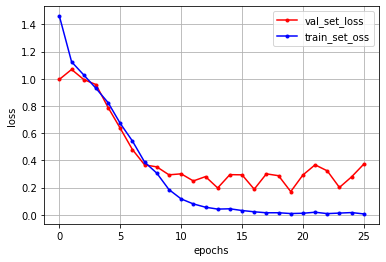

In [10]:
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

x_len = np.arange(len(y_loss))

plt.plot(x_len, y_vloss, marker='.', c='red', label='val_set_loss')
plt.plot(x_len, y_loss, marker='.', c='blue', label='train_set_oss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()
plt.show()

In [11]:
from PIL import Image
import os, glob, numpy as np
from keras.models import load_model

caltech_dir = "C:/Users/1-11/Pictures/car_test"
image_w = 64
image_h = 64

pixels = image_h * image_w * 3

X = []
filenames = []
files = glob.glob(caltech_dir+"/*.*")
for i, f in enumerate(files):
    img = Image.open(f)
    img = img.convert("RGB")
    img = img.resize((image_w, image_h))
    data = np.asarray(img)
    filenames.append(f)
    X.append(data)

X = np.array(X)
model = load_model('./model/multi_img_classification.model')

prediction = model.predict(X)
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
cnt = 0

#이 비교는 그냥 파일들이 있으면 해당 파일과 비교. 카테고리와 함께 비교해서 진행하는 것은 _4 파일.
for i in prediction:
    pre_ans = i.argmax()  # 예측 레이블
    print(i)
    print(pre_ans)
    pre_ans_str = ''
    if pre_ans == 0: pre_ans_str = "i30"
    elif pre_ans == 1: pre_ans_str = "스타렉스"
    else: pre_ans_str = "펠리세이드"
    if i[0] >= 0.8 : print("해당 "+filenames[cnt].split("\\")[1]+"이미지는 "+pre_ans_str+"로 추정됩니다.")
    if i[1] >= 0.8: print("해당 "+filenames[cnt].split("\\")[1]+"이미지는 "+pre_ans_str+"으로 추정됩니다.")
    if i[2] >= 0.8: print("해당 "+filenames[cnt].split("\\")[1]+"이미지는 "+pre_ans_str+"로 추정됩니다.")
    cnt += 1
    # print(i.argmax()) #얘가 레이블 [1. 0. 0.] 이런식으로 되어 있는 것을 숫자로 바꿔주는 것.
    # 즉 얘랑, 나중에 카테고리 데이터 불러와서 카테고리랑 비교를 해서 같으면 맞는거고, 아니면 틀린거로 취급하면 된다.
    # 이걸 한 것은 _4.py에.

[0.000 0.000 1.000]
2
해당 스타1.jpeg이미지는 펠리세이드로 추정됩니다.
[0.000 1.000 0.000]
1
해당 스타2.jpeg이미지는 스타렉스으로 추정됩니다.
[0.000 1.000 0.000]
1
해당 스타3.png이미지는 스타렉스으로 추정됩니다.
[0.000 0.000 1.000]
2
해당 스타4.jpg이미지는 펠리세이드로 추정됩니다.
[1.000 0.000 0.000]
0
해당 스타5.jpg이미지는 i30로 추정됩니다.
[0.000 0.000 1.000]
2
해당 써티1.jpeg이미지는 펠리세이드로 추정됩니다.
[0.000 0.000 1.000]
2
해당 써티2.jpeg이미지는 펠리세이드로 추정됩니다.
[1.000 0.000 0.000]
0
해당 써티3.jpeg이미지는 i30로 추정됩니다.
[0.000 0.000 1.000]
2
해당 써티4.jpg이미지는 펠리세이드로 추정됩니다.
[0.000 0.000 1.000]
2
해당 펠리1.jpg이미지는 펠리세이드로 추정됩니다.
[0.000 0.000 1.000]
2
해당 펠리2.jpg이미지는 펠리세이드로 추정됩니다.
[0.000 0.000 1.000]
2
해당 펠리3.jpg이미지는 펠리세이드로 추정됩니다.
[1.000 0.000 0.000]
0
해당 펠리4.jpg이미지는 i30로 추정됩니다.
[0.000 0.000 1.000]
2
해당 펠리5.jpg이미지는 펠리세이드로 추정됩니다.
